<h1>Piecewise linear regression and cubic splines</h1>



<h2>1. Continuous piecewise linear regression (CPLR)</h2>

Compare with bottom-left of Fig.5.1 on p.142, Hastie et al., 2nd ed.

https://link-springer-com.libproxy.york.ac.uk/content/pdf/10.1007%2F978-0-387-84858-7.pdf


breakpoint = (6.00,15.00)

 y = 2.00*x+ 3.00, x < 6.00

 y = 13.89*x+ -68.32, x >= 6.00



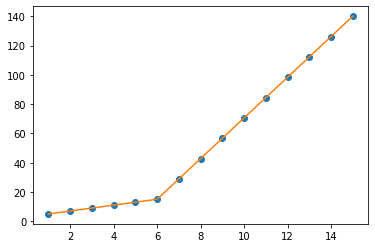

In [ ]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

def piecewise_linear(x, x0, y0, k1, k2):
    # look up numpy.piecewise
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# x0, y0, k1 and k2 in piecewise_linear are optimised to minimise nonlinear
# least squares.
p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(1, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

print("breakpoint = (%.2f,%.2f)"% (p[0],p[1]))
intercept1=p[1]-p[2]*p[0]
intercept2=p[1]-p[3]*p[0]
print("\n y = %.2f*x+ %.2f, x < %.2f" % (p[2],intercept1,p[0]))
print("\n y = %.2f*x+ %.2f, x >= %.2f\n" % (p[3],intercept2,p[0]))

Of course, one can take each of the two intervals and try to split it further. You can try modifying the above code



---



<h2>CPLR example with a fixed number of breakpoints (n >=2)</h2>

(Sensitive to the initial conditions - it won't always converge!)







In [ ]:
# [1]: Muggeo, V.M.(2003). Estimating regression models with unknown breakpoints.
# Statistics in medicine, 22(19), 3055-3071.
# Code by https://datascience.stackexchange.com/users/53362/xdze2
import numpy as np
from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution


Now run the actual example and experiment with a different number of breakpoints (also known as *knots*), and with different initial positions.

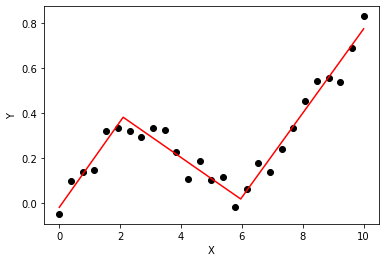

In [ ]:
import matplotlib.pyplot as plt

X = np.linspace( 0, 10, 27 )
Y = 0.2*X  - 0.3* ramp(X-2) + 0.3*ramp(X-6) + 0.05*np.random.randn(len(X))
plt.plot( X, Y, 'ok' );

initialBreakpoints = [1,7]
#Try also with 3 breakpoints, e.g. [3,5,6]
plt.plot( *SegmentedLinearReg( X, Y, initialBreakpoints ), '-r' );
plt.xlabel('X'); plt.ylabel('Y');



---




# Spline interpolation

This example demonstrates how to approximate a function with polynomials up to
degree ``degree`` by using ridge regression. Given
``n_samples`` of 1d points ``x_i``:


- :class:`~sklearn.preprocessing.SplineTransformer` generates B-spline basis
  functions. A basis function of a B-spline is a piece-wise polynomial function
  of degree ``degree`` that is non-zero only between ``degree+1`` consecutive
  knots. Given ``n_knots`` number of knots, this results in matrix of
  ``n_samples`` rows and ``n_knots + degree - 1`` columns::

    [[basis_1(x_0), basis_2(x_0), ...],
     [basis_1(x_1), basis_2(x_1), ...],
     ...]

This example shows that this transformer is well suited to model
non-linear effects with a linear model, using a pipeline to add non-linear
features.


In [ ]:
%matplotlib inline

In [ ]:
# Edited from the original: https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

We start by defining a function that we intend to approximate and prepare:



In [ ]:
def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)


# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)

To make it interesting, we only give a small subset of points to train on.



In [ ]:
x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

Now we are ready to create splines, fit on the
training points and show how well they interpolate.



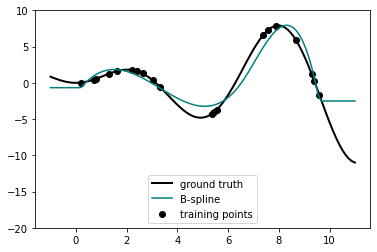

In [ ]:
# plot function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()

Higher degree polynomials may fit the data better. At the same time, too high powers can show unwanted oscillatory behaviour and are particularly dangerous for extrapolation beyond the range of fitted data. The advantage of B-splines is that they usually fit the data as well as polynomials and show very nice and smooth behaviour. They have also good options to control the extrapolation, which defaults to continue with a constant. Note that most often, you would rather increase the number of knots but keep ``degree=3``.

In order to give more insights into the generated feature bases, we plot the splines separately.



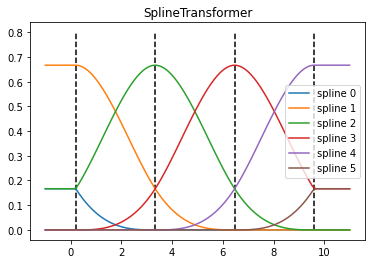

In [ ]:
fig, ax = plt.subplots()
splt = SplineTransformer(n_knots=4, degree=3).fit(X_train)
ax.plot(x_plot, splt.transform(X_plot))
ax.legend(ax.lines, [f"spline {n}" for n in range(6)])
ax.set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
ax.vlines(knots[3:-3], ymin=0, ymax=0.8, linestyles="dashed")
plt.show()

In the figure, we see the six B-spline basis functions of ``degree=3``
and also the four knot positions that were chosen during ``fit``.
Every basis function has local support and is continued as a constant beyond the fitted range. This extrapolating behaviour could be changed by the argument ``extrapolation``.

